<a href="https://colab.research.google.com/github/dung24mse13190/dl-res18/blob/main/DungTNT_DeepCNN12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepCNN for CIFAR-10: High-Accuracy Image Classification

# 1. Introduction
🎯 Project Goal
Train a DeepCNN model on CIFAR-10 dataset to achieve >90% accuracy

📊 Dataset Overview
CIFAR-10 consists of:

60,000 32x32 color images
10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
50,000 training images and 10,000 test images

# 2. Setup & Installation

## 2.1 Check GPU Availability

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import os
from collections import defaultdict

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

if torch.cuda.is_available():
    print(f'GPU Name: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')
    print(f'CUDA Version: {torch.version.cuda}')
    print(f'PyTorch Version: {torch.__version__}')
else:
    print("⚠️ GPU not available. Training will be slow!")
    print("Go to Runtime → Change runtime type → GPU")

Using device: cuda
GPU Name: Tesla T4
GPU Memory: 14.74 GB
CUDA Version: 12.6
PyTorch Version: 2.8.0+cu126


## 2.2 Set Random Seeds for Reproducibility


In [2]:
def set_seed(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("✅ Random seeds set for reproducibility")

✅ Random seeds set for reproducibility


# 3. Data Preparation & Augmentation


## 3.1 Configuration Class


In [3]:
class Config:
    def __init__(self):
        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Data parameters
        self.data_root = './data'
        self.batch_size = 128
        self.num_workers = 2
        self.num_classes = 10

        # Data augmentation
        self.cutout_size = 16
        self.use_cutout = True

        # CIFAR-10 statistics
        self.mean = (0.4914, 0.4822, 0.4465)
        self.std = (0.2023, 0.1994, 0.2010)

        # Training parameters for 12-layer CNN
        self.num_epochs = 100
        self.learning_rate = 0.01  # Higher than 18-layer, lower than shallow
        self.momentum = 0.9
        self.weight_decay = 5e-4
        self.lr_milestones = [60, 120, 160]
        self.lr_gamma = 0.2
        self.dropout_rate = 0.3  # Lower dropout for 12 layers
        self.use_gradient_clip = True
        self.clip_value = 1.0  # Less aggressive clipping
        self.save_path = 'deepcnn12_cifar10_best.pth'
        self.model_name = "12-Layer DeepCNN"

        # Display configuration
        self.print_freq = 50

        # Classes in CIFAR-10
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck')

config = Config()


## 3.2 Advanced Data Augmentation: Cutout


In [4]:
class Cutout:
    """
    Cutout augmentation: Randomly masks out square regions of the image
    This improves model robustness and generalization

    Reference: https://arxiv.org/abs/1708.04552
    """

    def __init__(self, size=4):
        self.size = size

    def __call__(self, image):
        """
        Args:
            image: Tensor image of size (C, H, W)
        Returns:
            Image with random square region cut out
        """
        h, w = image.size(1), image.size(2)
        mask = torch.ones((h, w), dtype=torch.float32)

        # Random center point
        y = torch.randint(h, (1,)).item()
        x = torch.randint(w, (1,)).item()

        # Calculate patch boundaries
        y1 = max(0, y - self.size // 2)
        y2 = min(h, y + self.size // 2)
        x1 = max(0, x - self.size // 2)
        x2 = min(w, x + self.size // 2)

        # Apply mask
        mask[y1:y2, x1:x2] = 0
        mask = mask.expand_as(image)
        image = image * mask

        return image

print("✅ Cutout augmentation class defined")

✅ Cutout augmentation class defined


## 3.3 Data Loading and Transformation


In [5]:
def get_data_loaders(config):
    """
    Create data loaders with augmentation for training and testing
    """

    # Training transforms with augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # Random crop with padding
        transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(config.mean, config.std),
    ])

    # Add Cutout if enabled
    if config.use_cutout:
        transform_train.transforms.append(Cutout(config.cutout_size))

    # Test transforms (no augmentation)
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(config.mean, config.std)
    ])

    # Download and load CIFAR-10
    print("📥 Downloading CIFAR-10 dataset...")

    trainset = torchvision.datasets.CIFAR10(
        root=config.data_root,
        train=True,
        download=True,
        transform=transform_train
    )

    testset = torchvision.datasets.CIFAR10(
        root=config.data_root,
        train=False,
        download=True,
        transform=transform_test
    )

    # Create data loaders
    trainloader = DataLoader(
        trainset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True
    )

    testloader = DataLoader(
        testset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )

    print(f"✅ Data loaded: {len(trainset)} training, {len(testset)} test samples")
    print(f"   Batches: {len(trainloader)} train, {len(testloader)} test")

    return trainloader, testloader, trainset.classes

# Load data
trainloader, testloader, classes = get_data_loaders(config)
print(f"Classes: {classes}")

📥 Downloading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:25<00:00, 6.75MB/s]


✅ Data loaded: 50000 training, 10000 test samples
   Batches: 391 train, 79 test
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3.4 Visualize Sample Images with Augmentation


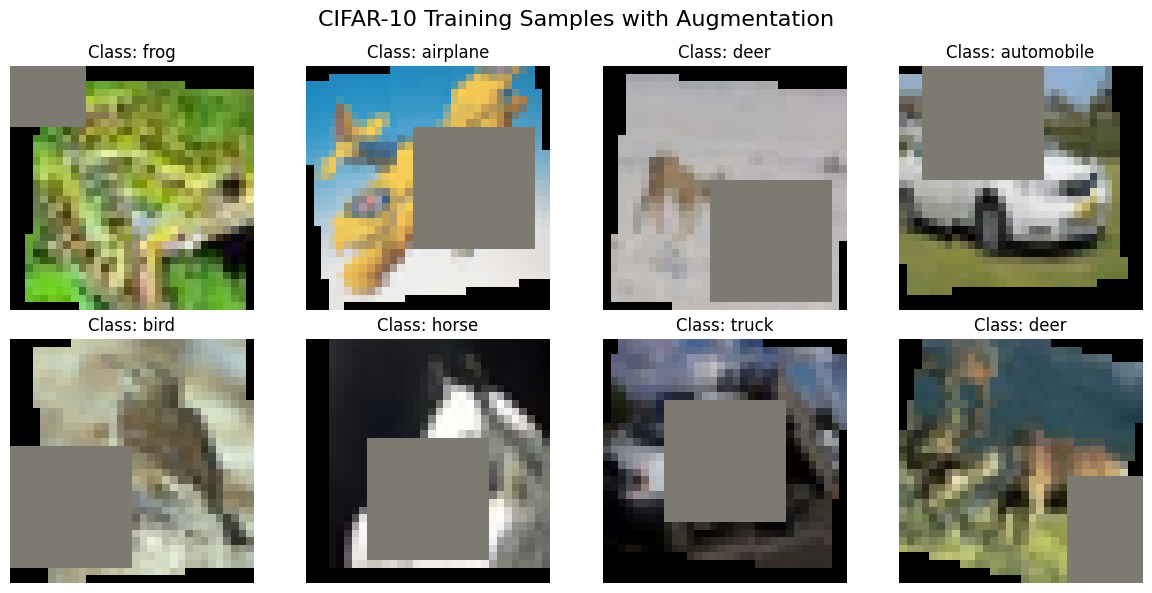

In [6]:
def visualize_augmented_samples(trainloader, classes, num_samples=8):
    """
    Visualize original and augmented samples
    """
    # Get a batch of images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # Denormalize for visualization
    def denormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return torch.clamp(tensor, 0, 1)

    # Select samples to display
    images_to_show = images[:num_samples].clone()

    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('CIFAR-10 Training Samples with Augmentation', fontsize=16)

    for idx, ax in enumerate(axes.flat):
        if idx < num_samples:
            img = denormalize(images_to_show[idx].clone(), config.mean, config.std)
            img = np.transpose(img.numpy(), (1, 2, 0))
            ax.imshow(img)
            ax.set_title(f'Class: {classes[labels[idx]]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_augmented_samples(trainloader, classes)

# 4. Model Implementation

## 4.1 Architecture

In [7]:
# Visualize DeepCNN-12 architecture
architecture_summary = """
DeepCNN-12 Architecture for CIFAR-10:
=====================================
Input: 32×32×3 (RGB image)
    ↓
Conv1: 3×3, 64 filters, stride=1
BatchNorm + ReLU
    ↓
Stage 1: 2 conv layers (64→64)     [32×32]
    Conv2: 3×3, 64 filters
    BatchNorm + ReLU
    Conv3: 3×3, 64 filters
    BatchNorm + ReLU + Dropout(0.3)
    ↓
Stage 2: 3 conv layers (64→128)    [16×16] (downsampling)
    Conv4: 3×3, 128 filters, stride=2
    BatchNorm + ReLU
    Conv5: 3×3, 128 filters
    BatchNorm + ReLU
    Conv6: 3×3, 128 filters
    BatchNorm + ReLU + Dropout(0.3)
    ↓
Stage 3: 3 conv layers (128→256)   [8×8] (downsampling)
    Conv7: 3×3, 256 filters, stride=2
    BatchNorm + ReLU
    Conv8: 3×3, 256 filters
    BatchNorm + ReLU
    Conv9: 3×3, 256 filters
    BatchNorm + ReLU + Dropout(0.3)
    ↓
Stage 4: 2 conv layers (256→512)   [4×4] (downsampling)
    Conv10: 3×3, 512 filters, stride=2
    BatchNorm + ReLU
    Conv11: 3×3, 512 filters
    BatchNorm + ReLU + Dropout(0.3)
    ↓
Global Average Pooling: 4×4 → 1×1
    ↓
Fully Connected: 512 → 10
    ↓
Output: 10 class probabilities
=====================================
Total layers: 12 (11 conv + 1 FC)
Parameters: ~11 million
NO skip connections (plain deep network)
=====================================
"""
print(architecture_summary)


DeepCNN-12 Architecture for CIFAR-10:
Input: 32×32×3 (RGB image)
    ↓
Conv1: 3×3, 64 filters, stride=1
BatchNorm + ReLU
    ↓
Stage 1: 2 conv layers (64→64)     [32×32]
    Conv2: 3×3, 64 filters
    BatchNorm + ReLU
    Conv3: 3×3, 64 filters
    BatchNorm + ReLU + Dropout(0.3)
    ↓
Stage 2: 3 conv layers (64→128)    [16×16] (downsampling)
    Conv4: 3×3, 128 filters, stride=2
    BatchNorm + ReLU
    Conv5: 3×3, 128 filters
    BatchNorm + ReLU
    Conv6: 3×3, 128 filters
    BatchNorm + ReLU + Dropout(0.3)
    ↓
Stage 3: 3 conv layers (128→256)   [8×8] (downsampling)
    Conv7: 3×3, 256 filters, stride=2
    BatchNorm + ReLU
    Conv8: 3×3, 256 filters
    BatchNorm + ReLU
    Conv9: 3×3, 256 filters
    BatchNorm + ReLU + Dropout(0.3)
    ↓
Stage 4: 2 conv layers (256→512)   [4×4] (downsampling)
    Conv10: 3×3, 512 filters, stride=2
    BatchNorm + ReLU
    Conv11: 3×3, 512 filters
    BatchNorm + ReLU + Dropout(0.3)
    ↓
Global Average Pooling: 4×4 → 1×1
    ↓
Fully Connected

## 4.2 Deep CNN Model


In [8]:
class DeepCNN12(nn.Module):
    """
    12-Layer Deep CNN for CIFAR-10 (without skip connections)

    Architecture:
    - 1 initial conv layer
    - 10 conv layers in 4 stages
    - 1 FC layer
    Total: 12 layers

    This depth is more manageable without skip connections while still being "deep"
    """

    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(DeepCNN12, self).__init__()

        # Initial layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Stage 1: 2 layers, 64 channels (32x32)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        # Stage 2: 3 layers, 128 channels (16x16)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(128)

        # Stage 3: 3 layers, 256 channels (8x8)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(256)
        self.conv9 = nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False)
        self.bn9 = nn.BatchNorm2d(256)

        # Stage 4: 2 layers, 512 channels (4x4)
        self.conv10 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn10 = nn.BatchNorm2d(512)
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False)
        self.bn11 = nn.BatchNorm2d(512)

        # Dropout (reduced for shallower network)
        self.dropout = nn.Dropout(dropout_rate)

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)  # Layer 12

        # Initialize weights with better initialization for deep networks
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using MSRA/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))

        # Stage 1: 64 channels (32x32)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)

        # Stage 2: 128 channels (16x16)
        x = F.relu(self.bn4(self.conv4(x)))  # Downsample
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout(x)

        # Stage 3: 256 channels (8x8)
        x = F.relu(self.bn7(self.conv7(x)))  # Downsample
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = self.dropout(x)

        # Stage 4: 512 channels (4x4)
        x = F.relu(self.bn10(self.conv10(x)))  # Downsample
        x = F.relu(self.bn11(self.conv11(x)))
        x = self.dropout(x)

        # Global pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [9]:
# ===============================================
# Model Creation with All Three Options
# ===============================================

def create_model(config):
    """Create model based on configuration"""

    model = DeepCNN12(
            num_classes=config.num_classes,
            dropout_rate=config.dropout_rate
        )

    model = model.to(config.device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Count layers
    conv_layers = sum(1 for m in model.modules() if isinstance(m, nn.Conv2d))
    print(f"Convolutional layers: {conv_layers}")

    return model

model = create_model(config)

Total parameters: 5,467,466
Trainable parameters: 5,467,466
Convolutional layers: 11


## 4.3 Test Model with Sample Input


In [10]:
model = DeepCNN12(
    num_classes=config.num_classes,
    dropout_rate=config.dropout_rate
).to(config.device)

# Test the model with a sample input
sample_input = torch.randn(1, 3, 32, 32).to(config.device)
sample_output = model(sample_input)
print(f"Sample input shape: {sample_input.shape}")
print(f"Sample output shape: {sample_output.shape}")
print(f"Output (logits): {sample_output[0][:5].detach().cpu().numpy()}")  # First 5 logits

Sample input shape: torch.Size([1, 3, 32, 32])
Sample output shape: torch.Size([1, 10])
Output (logits): [-0.05234497  0.0634542  -0.04177581  0.04535923 -0.15848115]


# 5. Training Pipeline

## 5.1 Training Utilities


In [11]:
class AverageMeter:
    """
    Computes and stores the average and current value
    Useful for tracking losses and accuracies
    """
    def __init__(self, name=''):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

print("✅ Training utilities defined")

✅ Training utilities defined


## 5.2 Training Function


In [12]:
def train_epoch(model, dataloader, criterion, optimizer, epoch, config):
    """
    Train for one epoch
    """
    batch_time = AverageMeter('Time')
    losses = AverageMeter('Loss')
    top1 = AverageMeter('Acc@1')

    # Switch to train mode
    model.train()

    end = time.time()
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(config.device, non_blocking=True)
        targets = targets.to(config.device, non_blocking=True)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Measure accuracy
        acc1, = accuracy(outputs, targets, topk=(1,))
        losses.update(loss.item(), inputs.size(0))
        top1.update(acc1.item(), inputs.size(0))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # ADD GRADIENT CLIPPING FOR DEEPCNN
        if config.use_gradient_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_value)

        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # Print progress
        if i % config.print_freq == 0:
            print(f'Epoch: [{epoch}][{i}/{len(dataloader)}] | '
                  f'Time {batch_time.val:.3f} ({batch_time.avg:.3f}) | '
                  f'Loss {losses.val:.4f} ({losses.avg:.4f}) | '
                  f'Acc {top1.val:.2f} ({top1.avg:.2f})')

    return top1.avg, losses.avg

def validate(model, testloader, criterion, config):
    """
    Validate the model on test set
    """
    batch_time = AverageMeter('Time')
    losses = AverageMeter('Loss')
    top1 = AverageMeter('Acc@1')

    # Switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(config.device, non_blocking=True)
            targets = targets.to(config.device, non_blocking=True)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Measure accuracy
            acc1, = accuracy(outputs, targets, topk=(1,))
            losses.update(loss.item(), inputs.size(0))
            top1.update(acc1.item(), inputs.size(0))

            # Measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

    print(f' * Test Acc@1 {top1.avg:.3f}')

    return top1.avg, losses.avg

print("✅ Training functions defined")

✅ Training functions defined


## 5.3 Main Training Loop


In [13]:
def train_model(model, trainloader, testloader, config):
    """
    Complete training pipeline
    """
    print("\n" + "="*60)
    print("Starting Training")
    print("="*60)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(config.device)

    # Optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=config.learning_rate,
        momentum=config.momentum,
        weight_decay=config.weight_decay
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=config.lr_milestones,
        gamma=config.lr_gamma
    )

    # Training history
    history = {
        'train_acc': [],
        'train_loss': [],
        'test_acc': [],
        'test_loss': [],
        'lr': []
    }

    best_acc = 0
    start_time = time.time()

    # Training loop
    for epoch in range(1, config.num_epochs + 1):
        print(f'\nEpoch: {epoch}/{config.num_epochs}')
        print('-' * 40)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {current_lr:.6f}')

        # Train for one epoch
        train_acc, train_loss = train_epoch(
            model, trainloader, criterion, optimizer, epoch, config
        )

        # Validate
        test_acc, test_loss = validate(model, testloader, criterion, config)

        # Update learning rate
        scheduler.step()

        # Save history
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_loss)
        history['lr'].append(current_lr)

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'history': history
            }, config.save_path)
            print(f'✅ New best model saved! Accuracy: {best_acc:.2f}%')

        # Print epoch summary
        print(f'Summary: Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Best: {best_acc:.2f}%')

    # Training completed
    elapsed_time = (time.time() - start_time) / 60
    print("\n" + "="*60)
    print(f"Training Completed in {elapsed_time:.2f} minutes!")
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print("="*60)

    return history, best_acc

# Train the model
history, best_acc = train_model(model, trainloader, testloader, config)


Starting Training

Epoch: 1/100
----------------------------------------
Learning Rate: 0.010000
Epoch: [1][0/391] | Time 1.014 (1.014) | Loss 2.3062 (2.3062) | Acc 9.38 (9.38)
Epoch: [1][50/391] | Time 0.061 (0.084) | Loss 2.1358 (2.2296) | Acc 26.56 (15.78)
Epoch: [1][100/391] | Time 0.072 (0.074) | Loss 1.9924 (2.1399) | Acc 22.66 (18.19)
Epoch: [1][150/391] | Time 0.081 (0.076) | Loss 1.9270 (2.0824) | Acc 24.22 (19.80)
Epoch: [1][200/391] | Time 0.059 (0.074) | Loss 1.8433 (2.0378) | Acc 35.94 (21.62)
Epoch: [1][250/391] | Time 0.074 (0.072) | Loss 1.9063 (1.9998) | Acc 26.56 (23.04)
Epoch: [1][300/391] | Time 0.061 (0.071) | Loss 1.9022 (1.9705) | Acc 28.12 (24.11)
Epoch: [1][350/391] | Time 0.064 (0.072) | Loss 1.8181 (1.9446) | Acc 31.25 (25.12)
 * Test Acc@1 28.820
✅ New best model saved! Accuracy: 28.82%
Summary: Train Acc: 25.73% | Test Acc: 28.82% | Best: 28.82%

Epoch: 2/100
----------------------------------------
Learning Rate: 0.010000
Epoch: [2][0/391] | Time 0.190 (0

# 6. Results & Visualization


## 6.1 Plot Training History


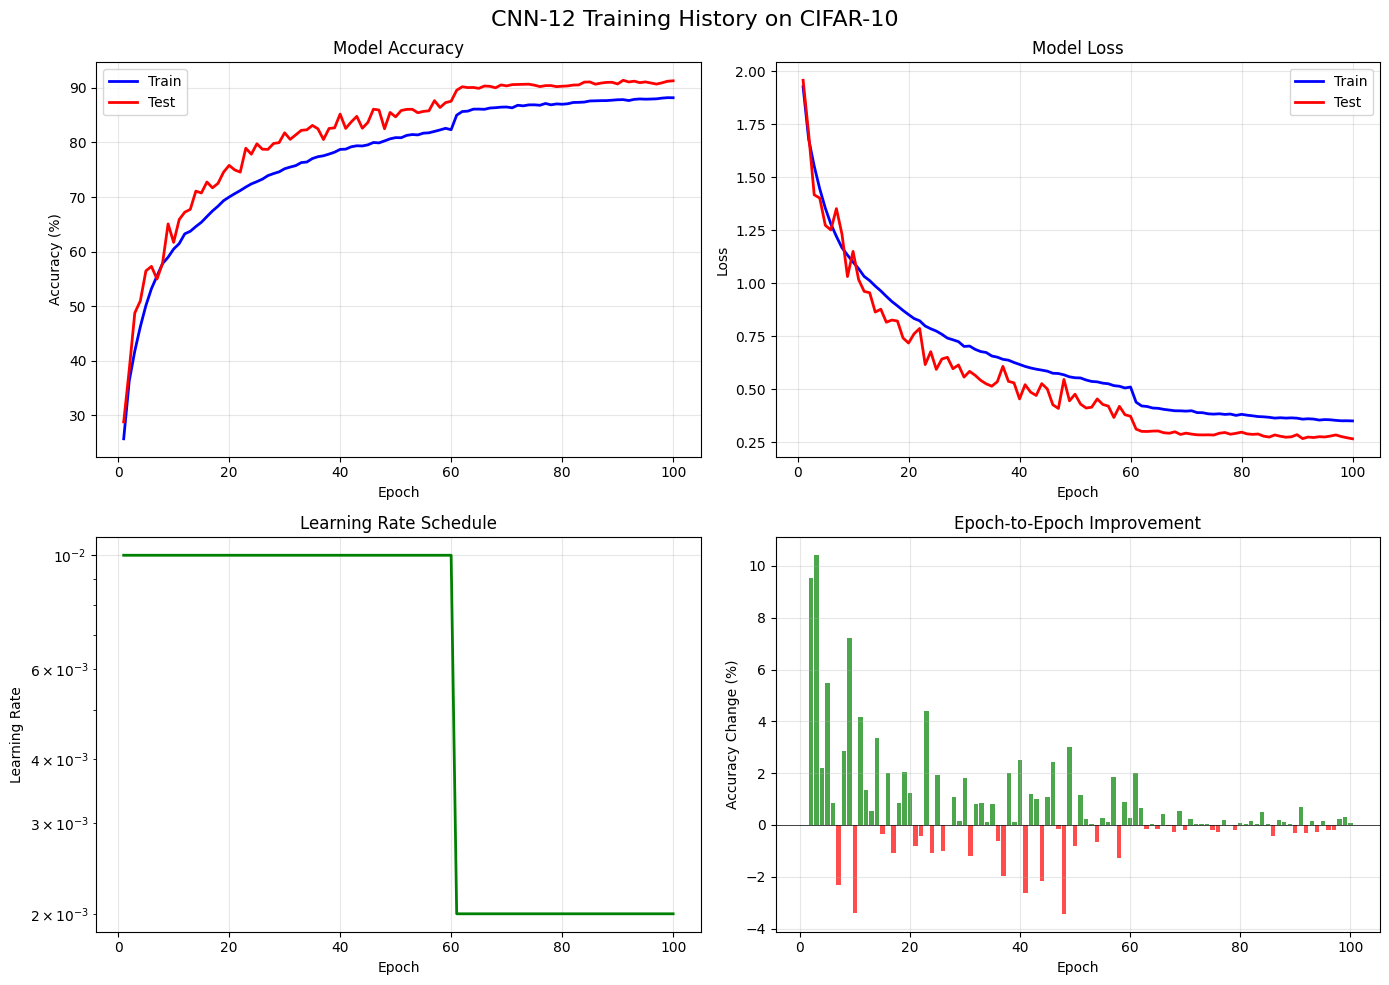

In [22]:
def plot_training_history(history):
    """
    Visualize training metrics over epochs
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('CNN-12 Training History on CIFAR-10', fontsize=16)

    epochs = range(1, len(history['train_acc']) + 1)

    # Accuracy plot
    axes[0, 0].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
    axes[0, 0].plot(epochs, history['test_acc'], 'r-', label='Test', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss plot
    axes[0, 1].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0, 1].plot(epochs, history['test_loss'], 'r-', label='Test', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate plot
    axes[1, 0].plot(epochs, history['lr'], 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # Accuracy improvement over time
    test_acc = history['test_acc']
    improvements = [test_acc[i] - test_acc[i-1] if i > 0 else 0 for i in range(len(test_acc))]
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    axes[1, 1].bar(epochs, improvements, color=colors, alpha=0.7)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Change (%)')
    axes[1, 1].set_title('Epoch-to-Epoch Improvement')
    axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## 6.2 Final Results Summary


In [23]:
def print_final_results(history, best_acc):
    """
    Print comprehensive training results
    """
    print("\n" + "="*60)
    print("FINAL RESULTS SUMMARY")
    print("="*60)

    print(f"✅ Best Test Accuracy: {best_acc:.2f}%")
    print(f"📊 Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"📊 Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
    print(f"📉 Final Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"📉 Final Test Loss: {history['test_loss'][-1]:.4f}")

    # Find epoch with best accuracy
    best_epoch = history['test_acc'].index(max(history['test_acc'])) + 1
    print(f"🎯 Best accuracy achieved at epoch: {best_epoch}")

    # Calculate average accuracy over last 10 epochs
    if len(history['test_acc']) >= 10:
        avg_last_10 = np.mean(history['test_acc'][-10:])
        print(f"📈 Average test accuracy (last 10 epochs): {avg_last_10:.2f}%")

    print("="*60)

print_final_results(history, best_acc)


FINAL RESULTS SUMMARY
✅ Best Test Accuracy: 91.38%
📊 Final Train Accuracy: 88.18%
📊 Final Test Accuracy: 91.28%
📉 Final Train Loss: 0.3513
📉 Final Test Loss: 0.2670
🎯 Best accuracy achieved at epoch: 91
📈 Average test accuracy (last 10 epochs): 91.06%


# 7. Model Evaluation & Testing

## 7.1 Load Best Model and Evaluate


In [24]:
def load_best_model(model, config):
    """
    Load the best saved model
    """
    checkpoint = torch.load(config.save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded best model from epoch {checkpoint['epoch']} with accuracy {checkpoint['best_acc']:.2f}%")
    return model

# Load best model
model = load_best_model(model, config)

✅ Loaded best model from epoch 91 with accuracy 91.38%


## 7.2 Detailed Class-wise Performance



CLASS-WISE PERFORMANCE
airplane  : 93.60% (936/1000)
automobile: 96.80% (968/1000)
bird      : 88.00% (880/1000)
cat       : 82.00% (820/1000)
deer      : 91.80% (918/1000)
dog       : 83.10% (831/1000)
frog      : 95.20% (952/1000)
horse     : 92.60% (926/1000)
ship      : 95.70% (957/1000)
truck     : 95.00% (950/1000)
------------------------------------------------------------
Overall Average: 91.38%


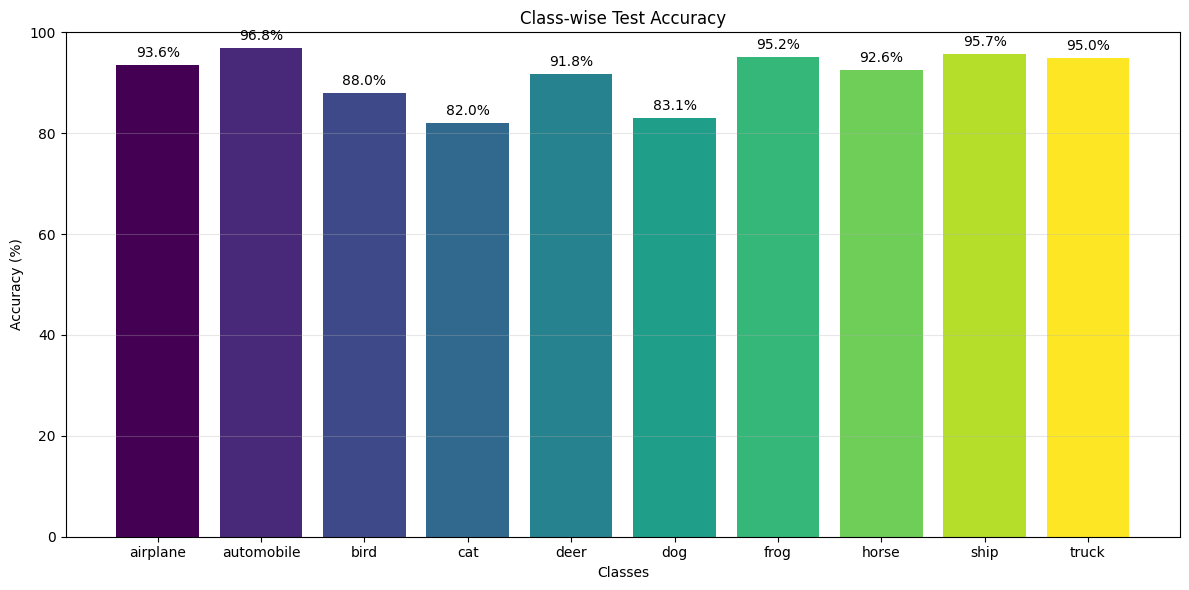

In [25]:
def evaluate_classwise_performance(model, testloader, classes, config):
    """
    Evaluate model performance for each class
    """
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    model.eval()
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs = inputs.to(config.device)
            targets = targets.to(config.device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == targets).squeeze()

            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Print results
    print("\n" + "="*60)
    print("CLASS-WISE PERFORMANCE")
    print("="*60)

    accuracies = []
    for i in range(len(classes)):
        acc = 100 * class_correct[i] / class_total[i]
        accuracies.append(acc)
        print(f'{classes[i]:10s}: {acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')

    print("-"*60)
    print(f'Overall Average: {np.mean(accuracies):.2f}%')
    print("="*60)

    # Visualize class-wise performance
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
    bars = plt.bar(classes, accuracies, color=colors)
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Test Accuracy')
    plt.ylim([0, 100])

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom')

    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    return accuracies

class_accuracies = evaluate_classwise_performance(model, testloader, classes, config)

## 7.3 Confusion Matrix


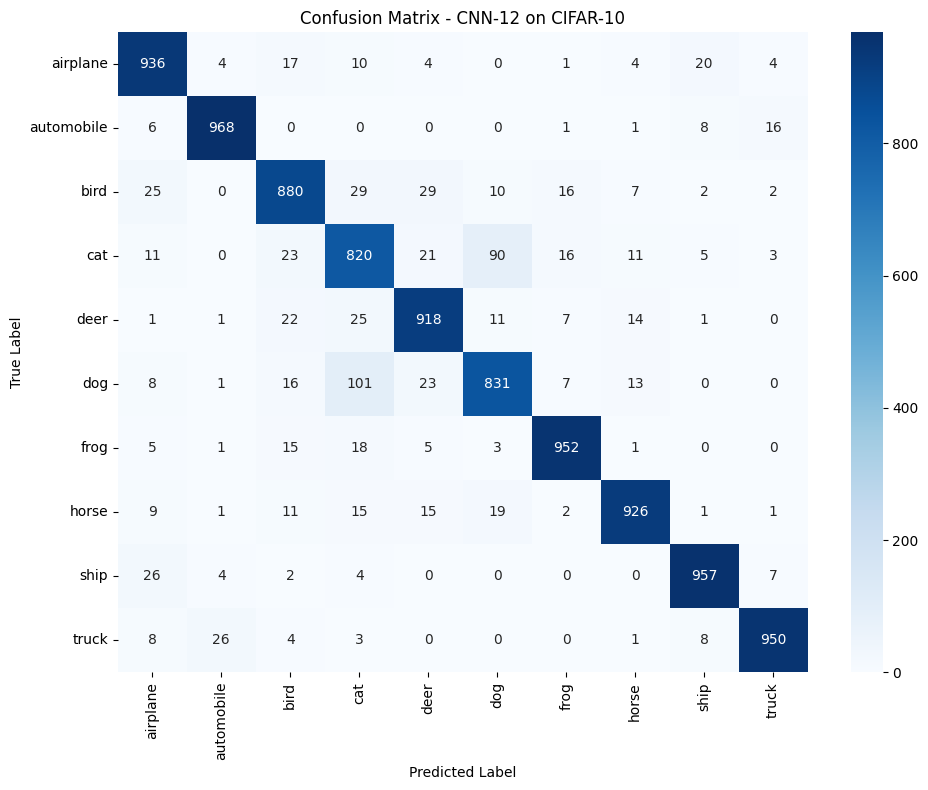

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, testloader, classes, config):
    """
    Generate and plot confusion matrix
    """
    all_targets = []
    all_predictions = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs = inputs.to(config.device)
            targets = targets.to(config.device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - CNN-12 on CIFAR-10')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return cm

cm = plot_confusion_matrix(model, testloader, classes, config)

## 7.4 Visualize Model Predictions


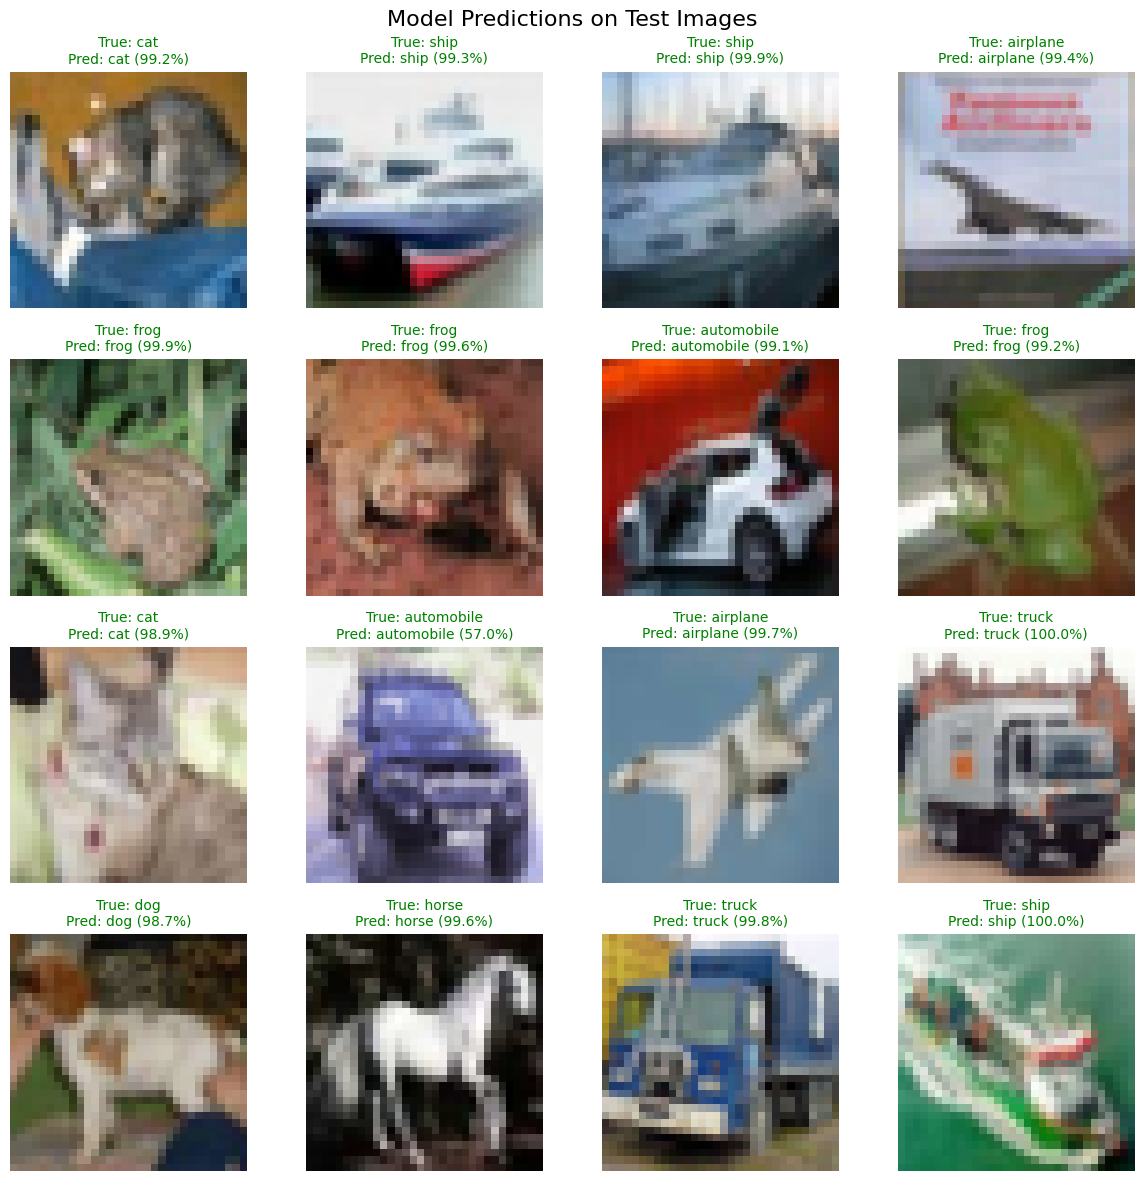

In [27]:
def visualize_predictions(model, testloader, classes, config, num_images=16):
    """
    Visualize model predictions on random test images
    """
    model.eval()

    # Get random batch
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images = images[:num_images]
    labels = labels[:num_images]

    # Get predictions
    with torch.no_grad():
        outputs = model(images.to(config.device))
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        confidences, _ = torch.max(probs, 1)

    # Denormalize images
    def denormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return torch.clamp(tensor, 0, 1)

    # Plot
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Model Predictions on Test Images', fontsize=16)

    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            img = denormalize(images[idx].clone(), config.mean, config.std)
            img = np.transpose(img.numpy(), (1, 2, 0))

            ax.imshow(img)

            true_label = classes[labels[idx]]
            pred_label = classes[predicted[idx]]
            confidence = confidences[idx].item() * 100

            color = 'green' if labels[idx] == predicted[idx] else 'red'
            ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                        color=color, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, testloader, classes, config)